Training CNN using callbacks and Data Generators 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D ,MaxPool2D  
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator  
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


In [2]:
from os import makedirs
from os.path import exists, join

In [3]:
batch_size=20
log_dir = './logs-cnn'
epochs = 10
batch_size = 64
if not exists(log_dir):
    makedirs(log_dir)


In [4]:
from os.path import exists, join

In [5]:
sns.set(style='white', context='notebook', palette='deep')

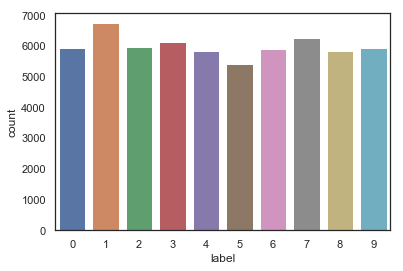

In [6]:
X_train = pd.read_csv('./mnist_train.csv')
X_test = pd.read_csv('./mnist_test.csv')
y_train = X_train['label']
X_train = X_train.drop(labels=['label'], axis=1)
g = sns.countplot(y_train)

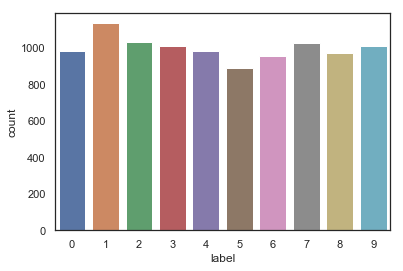

In [7]:
y_test = X_test['label']
X_test = X_test.drop(labels=['label'], axis=1)
g = sns.countplot(y_test)

In [8]:
y_train.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

In [9]:
y_test.value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

In [10]:
#check for null and missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

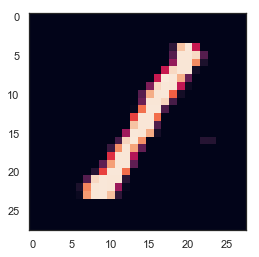

In [12]:
#Normalization
X_train = X_train / 255
X_test = X_test / 255

#Reshape
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

#Encode labels to one hot vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#split training and validation set for the fitting
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.1,
                                                 random_state=random_seed)
g = plt.imshow(X_train[777][:,:,0])

In [13]:
# save class labels to disk to color data points in TensorBoard accordingly
with open(join(log_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, y_val)

In [14]:
tensorboard = TensorBoard(batch_size=batch_size,
                          embeddings_freq=1,
                          embeddings_layer_names=['features'],
                          embeddings_metadata='metadata.tsv',
                          embeddings_data= X_val,
                          histogram_freq=0, 
                          write_graph=True, 
                          write_grads=False, 
                          write_images=False, 
                          update_freq='epoch',
                          log_dir=log_dir )

In [15]:
#CNN model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same',
                 activation='relu', input_shape =(28,28,1)))
model.add(Conv2D(32,(3,3), padding='same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), padding='same',
                activation='relu'))
model.add(Conv2D(64,(3,3), padding='same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu',name='features'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

W0703 15:41:55.168592  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 15:41:55.188669  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 15:41:55.196672  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 15:41:55.288675  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 15:41:55.324679  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
__________

In [16]:
#set optimizer and annealer
optimizer = Adam(epsilon=1e-08)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
             metrics=['accuracy'])

W0703 15:41:56.063860  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [17]:
#data augmentation
datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2)
datagen.fit(X_train)

In [18]:
history = model.fit_generator(datagen.flow(x = X_train, y = y_train, batch_size = batch_size),
                              callbacks=[tensorboard ],#callbacks_list,
                              epochs = epochs, 
                              verbose = 1,
                              validation_data = (X_val, y_val), 
                             steps_per_epoch = batch_size 
                              #steps_per_epoch = X_train.shape[0] // batch_size
                   )

W0703 15:41:57.164281  2280 deprecation.py:323] From C:\Users\Noor\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0703 15:41:59.021970  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0703 15:41:59.021970  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0703 15:41:59.601244  2280 deprecation_wrapper.py:119] From C:\Users\Noor\Anaconda3\lib\site-packages\keras\callbacks.py:887: The name tf.train.Saver is deprecated. Please use tf.compat.v

Epoch 1/10
64/64 [==============================] - 33s 513ms/step - loss: 1.8841 - acc: 0.4355 - val_loss: 2.8909 - val_acc: 0.1705
Epoch 2/10
64/64 [==============================] - 32s 493ms/step - loss: 0.7957 - acc: 0.7385 - val_loss: 2.9099 - val_acc: 0.2167
Epoch 3/10
64/64 [==============================] - 32s 493ms/step - loss: 0.5396 - acc: 0.8250 - val_loss: 6.5082 - val_acc: 0.0983
Epoch 4/10
64/64 [==============================] - 32s 493ms/step - loss: 0.4023 - acc: 0.8777 - val_loss: 7.9633 - val_acc: 0.0983
Epoch 5/10
64/64 [==============================] - 31s 490ms/step - loss: 0.3206 - acc: 0.8997 - val_loss: 13.1074 - val_acc: 0.0983
Epoch 6/10
64/64 [==============================] - 31s 490ms/step - loss: 0.3328 - acc: 0.8965 - val_loss: 12.0182 - val_acc: 0.0983


W0703 15:49:52.372736  2280 deprecation.py:323] From C:\Users\Noor\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch 7/10
64/64 [==============================] - 31s 490ms/step - loss: 0.2944 - acc: 0.9099 - val_loss: 11.4486 - val_acc: 0.0983
Epoch 8/10
64/64 [==============================] - 31s 488ms/step - loss: 0.2506 - acc: 0.9216 - val_loss: 11.5126 - val_acc: 0.0983
Epoch 9/10
64/64 [==============================] - 31s 488ms/step - loss: 0.2602 - acc: 0.9233 - val_loss: 14.1361 - val_acc: 0.0983
Epoch 10/10
64/64 [==============================] - 31s 487ms/step - loss: 0.2224 - acc: 0.9387 - val_loss: 14.2941 - val_acc: 0.0983


Training Deep nN using callbacks and Data Generators 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D ,MaxPool2D  
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator  
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization


In [20]:
import tensorflow as tf
# To ignore keep_dims warning
tf.logging.set_verbosity(tf.logging.ERROR)

In [21]:
from os import makedirs
from os.path import exists, join

In [22]:
batch_size=20
log_dir = './logs-dnn'
epochs = 10
batch_size = 64
if not exists(log_dir):
    makedirs(log_dir)


In [23]:
from os.path import exists, join

In [24]:
sns.set(style='white', context='notebook', palette='deep')

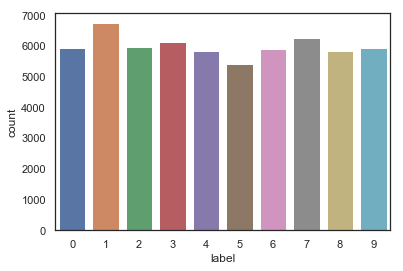

In [25]:
X_train = pd.read_csv('./mnist_train.csv')
X_test = pd.read_csv('./mnist_test.csv')
y_train = X_train['label']
X_train = X_train.drop(labels=['label'], axis=1)
g = sns.countplot(y_train)

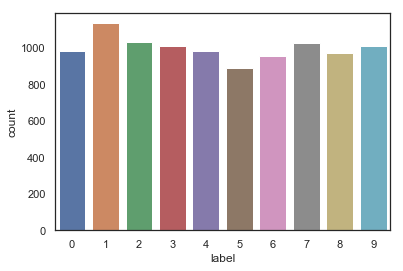

In [26]:
y_test = X_test['label']
X_test = X_test.drop(labels=['label'], axis=1)
g = sns.countplot(y_test)

In [27]:
y_train.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

In [28]:
y_test.value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

In [29]:
#check for null and missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [30]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

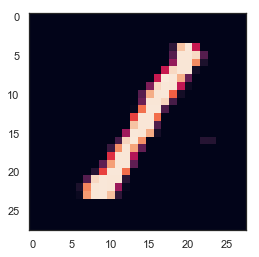

In [31]:
#Normalization
X_train = X_train / 255
X_test = X_test / 255

#Reshape
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

#Encode labels to one hot vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#split training and validation set for the fitting
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.1,
                                                 random_state=random_seed)
g = plt.imshow(X_train[777][:,:,0])

In [32]:
# save class labels to disk to color data points in TensorBoard accordingly
with open(join(log_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, y_val)

In [33]:
tensorboard2 = TensorBoard(batch_size=batch_size,
                          embeddings_freq=1,
                          embeddings_layer_names=['features'],
                          embeddings_metadata='metadata.tsv',
                          embeddings_data= X_val,
                          histogram_freq=0, 
                          write_graph=True, 
                          write_grads=False, 
                          write_images=False, 
                          update_freq='epoch',
                          log_dir=log_dir )

In [34]:
model2 = Sequential()
model2.add(Flatten(input_shape=(28,28,1))),
model2.add(Dense(128, activation=tf.nn.relu, name='features'))
# output = relu (dot (W, input) + bias)
model2.add(Dense(10, activation=tf.nn.softmax))

In [35]:
#set optimizer and annealer
optimizer = Adam(epsilon=1e-08)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy',
             metrics=['accuracy'])

In [36]:
#data augmentation
datagen2 = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2)
datagen2.fit(X_train)

In [37]:
history2 = model2.fit_generator(datagen.flow(x = X_train, y = y_train, batch_size = batch_size),
                              callbacks=[tensorboard2 ],#callbacks_list,
                              epochs = epochs, 
                              verbose = 1,
                              validation_data = (X_val, y_val), 
                              steps_per_epoch = batch_size 
                              #steps_per_epoch = X_train.shape[0] // batch_size
                   )

Epoch 1/10
64/64 [==============================] - 2s 39ms/step - loss: 1.9233 - acc: 0.3411 - val_loss: 2.1491 - val_acc: 0.2243
Epoch 2/10
64/64 [==============================] - 2s 34ms/step - loss: 1.4020 - acc: 0.5354 - val_loss: 2.0109 - val_acc: 0.3327
Epoch 3/10
64/64 [==============================] - 2s 31ms/step - loss: 1.1622 - acc: 0.6316 - val_loss: 1.8869 - val_acc: 0.3920
Epoch 4/10
64/64 [==============================] - 2s 30ms/step - loss: 1.0062 - acc: 0.6860 - val_loss: 1.8019 - val_acc: 0.4230
Epoch 5/10
64/64 [==============================] - 2s 31ms/step - loss: 0.8802 - acc: 0.7253 - val_loss: 1.6965 - val_acc: 0.4487
Epoch 6/10
64/64 [==============================] - 2s 33ms/step - loss: 0.7981 - acc: 0.7493 - val_loss: 1.6333 - val_acc: 0.4992
Epoch 7/10
64/64 [==============================] - 2s 30ms/step - loss: 0.7373 - acc: 0.7766 - val_loss: 1.5507 - val_acc: 0.4980
Epoch 8/10
64/64 [==============================] - 2s 30ms/step - loss: 0.6955 - a